In [13]:
import cv2
import json
import os
from glob import glob
from PIL import Image
import numpy as np
from tqdm import tqdm
import shutil
import torch
import torchvision
from typing import List
import random
from matplotlib import pyplot as plt

# 将image转移到指定目录

In [2]:
filenames = glob('../data/raw_data/*.tif')
len(filenames)

1151

In [4]:
target_file = "../data/grass/img"
if not os.path.exists(target_file):
    os.makedirs(target_file)
for filename in filenames:
    shutil.move(filename,target_file)

# 生成对应的mask文件并保存到指定路径下

In [5]:
json_filenames = glob('../data/raw_data/*.json')
len(json_filenames)

1151

In [6]:
for filename in tqdm(json_filenames):
    json_file = json.load(open(filename,mode='r'))
    img_height = json_file['imageHeight']
    img_width = json_file['imageWidth']
    mask = np.zeros((img_height,img_width),dtype='int8')
    for shape in json_file['shapes']:
        label = int(shape['label'])
        points = np.array(shape['points']).astype(np.int32)
        cv2.fillPoly(mask,[points],label)
    imagePath = json_file['imagePath'].split('.')[0]
    mask = Image.fromarray(mask)
    mask.save(f"../data/grass/mask/{imagePath}.png")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:02<00:00, 403.37it/s]


# 可视化展示一下效果

In [23]:
def pasteImages(images:List[np.ndarray]):
    """
    将两张图片粘贴在一起
    """
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    width = sum(widths)
    height = max(heights)
    paste_img = Image.new('RGB',(width,height))
    offset_x = 0
    for img in images:
        pil_img = Image.fromarray(img)
        paste_img.paste(pil_img,(offset_x, 0))
        offset_x += img.shape[1]
    return np.array(paste_img)

def give_colors_to_mask(image:np.ndarray, mask:np.ndarray,num_classes=6):
    image_tensor = torch.tensor(image).permute(2,1,0)
    masks = [mask == v for v in range(num_classes)]
    mask = np.stack(masks,axis=0).astype('bool')
    mask_tensor = torch.tensor(mask)
    colors = [
    "#ffffff",  # 白色    荒地
    "#a8d5ba",  # 浅绿    低覆盖度
    "#6cc551",  # 中浅绿   中低覆盖度
    "#4caf50",  # 中绿     中覆盖度
    "#388e3c",  # 中深绿    中高覆盖度
    "#1b5e20"   # 深绿     高覆盖度
    ]

    mask_colors = torchvision.utils.draw_segmentation_masks(image_tensor,mask_tensor,colors=colors,alpha=1.0).permute(1,2,0).numpy().astype(np.uint8)
    return mask_colors

In [24]:
filenames = glob('../data/grass/img/*.tif')
choice_filenames = random.choices(filenames,k=9)
len(choice_filenames)

9

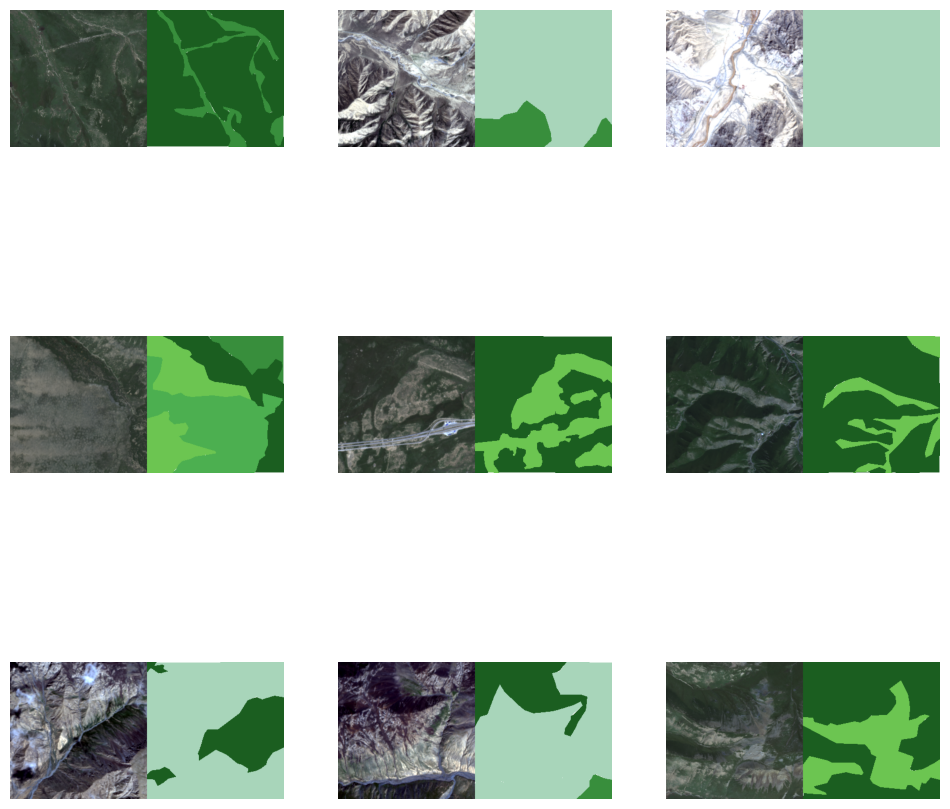

In [25]:
show_images = []
for filepath in choice_filenames:
    filename = filepath.split(os.path.sep)[-1].split('.')[0]
    mask_path = f'../data/grass/mask/{filename}.png'
    image = np.array(Image.open(filepath))
    mask = np.array(Image.open(mask_path))
    mask_colors = give_colors_to_mask(image,mask)
    paste_img = pasteImages([image,mask_colors])
    show_images.append(paste_img)
    
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.axis('off')
    plt.imshow(show_images[i * 3])
    
    plt.subplot(3,3,i*3+2)
    plt.axis('off')
    plt.imshow(show_images[i * 3 + 1])

    plt.subplot(3,3,i*3+3)
    plt.axis('off')
    plt.imshow(show_images[i * 3 + 2])
plt.show()